In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import os, sys
sys.path.append(os.path.relpath("./src"))
from kitaev_chain import kitaev_chain_model
from utils import to_n, s0, sx, sy, sz, power_set, tensor_product, canon_eigen, expm, U, c, zero

In [3]:
n = 5
k = 0.01
H0 = kitaev_chain_model(n, k, 1 - k, 1 - k)
#H0 = kitaev_chain_model(n, 1, 2, 3)
H0.bdg_eigen()

U, V numerical incompabillity


# Validate $H_{tfim}$ = $\sum_{i}{E_{i}\psi_{i}^{\dagger}\psi_{i}}$

#### Results:
* Needed to scale $H_{tfim}$ by 0.5 and zero out the ground energy
* JW transformation on the Hamiltonian before the anticommutation splits gets the same energy spectrum but with different eigenvectors

In [4]:
H_bdg = H0.bdg_hamiltonian()

H_tfim_bdg_recon = sum([
    sum([  H_bdg[i][j] * c(i, n, True) @ c(j, n)
         + H_bdg[i + n][j] * c(i, n) @ c(j, n)
         + H_bdg[i][j + n] * c(i, n, True) @ c(j, n, True)
         + H_bdg[i + n][j + n] * c(i, n) @ c(j, n, True)
         for j in range(n)])
     for i in range(n)])
# same as:
H_tfim_bdg =  H0.tfim_hamiltonian_JW_on_bdg()

#H_tfim_orig = H0.tfim_hamiltonian_JW_on_orig()
H_tfim_orig = H0.tfim_hamiltonian_JW_on_bdg_before_split()

H_tfim_recon = sum([H0.bdg_evals_sorted[i] * (H0.psi(i, dagger=True) @ H0.psi(i)) for i in range(n)])

H_tfim_JW = H0.tfim_hamiltonian_JW()

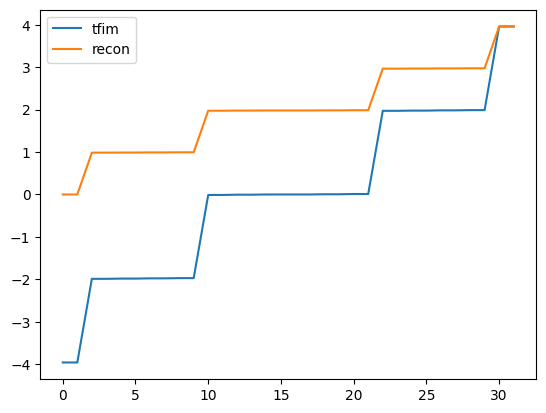

In [5]:
def orthopart(v, Av):
    return Av - v * np.dot(Av.T, v) / np.linalg.norm(v)

evals1, evecs1 = np.linalg.eigh(H_tfim_JW)
evals2, evecs2 = np.linalg.eigh(H_tfim_recon)
H_tfim_JW = 0.5 * (H0.tfim_hamiltonian_JW() - evals1[0] * np.eye(H0.N))

#plt.plot([np.dot(e, H_tfim_recon @ e) for e in evecs1.T], label='bdg')
plt.plot(evals1, label='tfim')
plt.plot(evals2, label='recon')
plt.legend()
plt.show()

In [6]:
H_tfim = H_tfim_JW

H0.tfim_vac_from_intersections()

f = lambda A: expm(1j * A, 100)

Tfim_Matrix_Elements = np.array([
    [(H0.vac.T.conj() @ H0.psi(i, True).T.conj() @ f(H_tfim) @ H0.psi(j, True) @ H0.vac)[0][0] for j in range(n)] for i in range(n)
])

BdG_Matrix_Elements = np.array([
    [(H0.bdg_evecs_sorted[:,i].T.conj() @ f(H_bdg) @ H0.bdg_evecs_sorted[:,j]) for j in range(n)] for i in range(n)
])


if np.allclose(Tfim_Matrix_Elements, BdG_Matrix_Elements):
    print("Parity between representations")
else:
    plt.imshow(np.real(Tfim_Matrix_Elements - BdG_Matrix_Elements))
    plt.title("Comparison of matrix elements $\\langle\\psi_{i}|H|\\psi_{j}\\rangle$")
    plt.colorbar()
    plt.show()

Parity between representations


## Vaccum state from G / Intersections

### Test: $\^{\psi}^{\dagger}_{i}\^{\psi}_{i} \^{\psi}^{\dagger}_{j}\ket{vac} = \delta^{j}_{i}\^{\psi}^{\dagger}_{j}\ket{vac}$

### Test: $\^H_{tfim}\^{\psi}^{\dagger}_{j}\ket{vac} = 2E_{j}\^{\psi}^{\dagger}_{j}\ket{vac}$

<>:20: SyntaxWarning: invalid escape sequence '\|'
<>:20: SyntaxWarning: invalid escape sequence '\|'
C:\Users\t-hareldamti\AppData\Local\Temp\ipykernel_47660\1871349892.py:20: SyntaxWarning: invalid escape sequence '\|'
  plt.title("$\|\{\psi_{i},\psi_{j}^{\dagger}\}\|$")


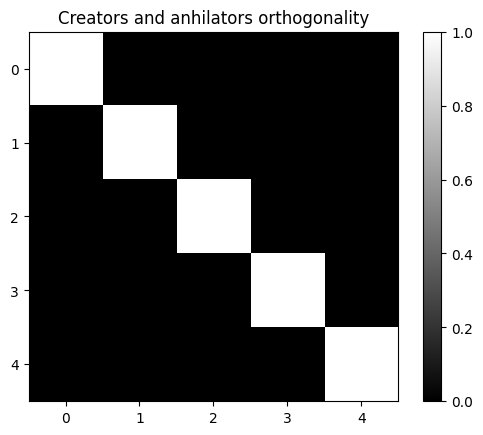

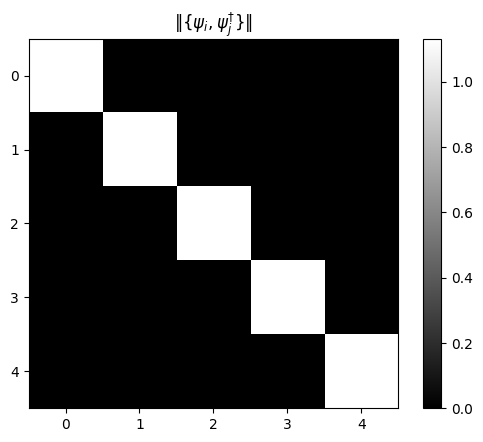

In [7]:
H0.tfim_vac_from_intersections()
id = np.zeros((n, n)).astype(np.float64)
for i in range(n):
    for j in range(n):
        a = H0.psi(i, dagger=True) @ H0.psi(i) @ H0.psi(j, dagger=True) @ H0.vac
        id[i, j] = np.linalg.norm(a)
plt.imshow(np.abs(id), cmap='gray')
plt.colorbar()
plt.title("Creators and anhilators orthogonality")
plt.show()

id = np.zeros((n, n)).astype(np.float64)
for i in range(n):
    for j in range(n):
        a = H0.psi(j, dagger=True) @ H0.psi(i)
        b = H0.psi(i) @ H0.psi(j, dagger=True)
        id[i, j] = np.linalg.norm(a + b) / n
plt.imshow(np.abs(id), cmap='gray')
plt.colorbar()
plt.title("$\|\{\psi_{i},\psi_{j}^{\dagger}\}\|$")
plt.show()


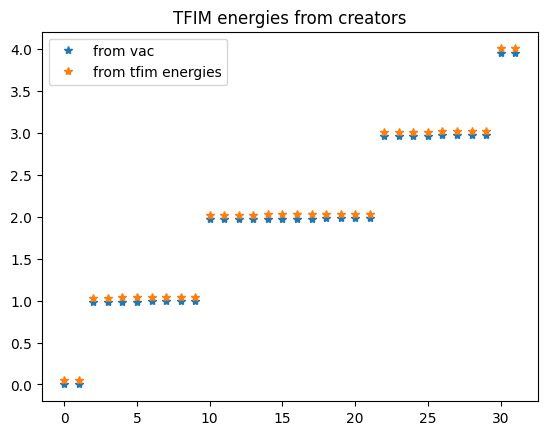

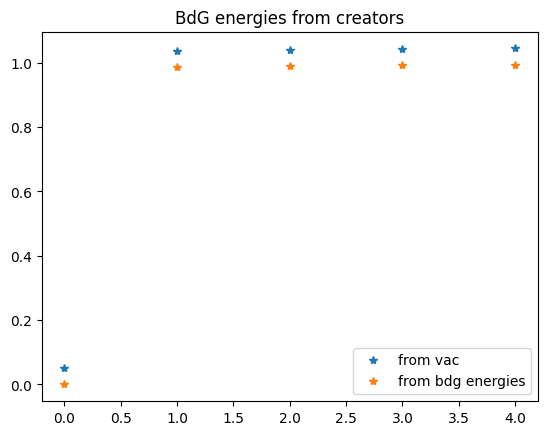

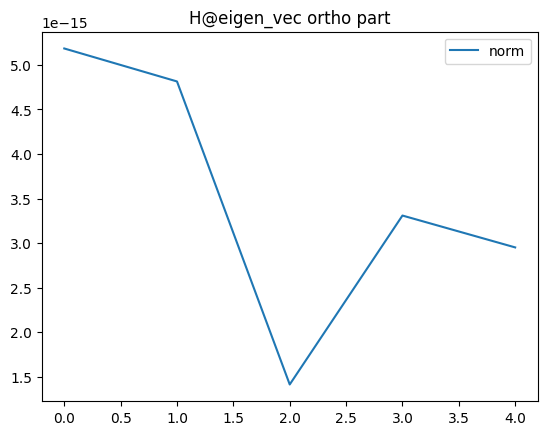

In [8]:
subsets = [[i for i in range(n) if l[i]] for l in power_set(n)]
states = []
for subset in subsets:
    psi_ = H0.vac
    for i in subset:
        psi_ = H0.psi(i, dagger=True) @ psi_
    states.append(psi_)
evals_comp_from_vac = [np.linalg.norm(psi_.T @ H_tfim @ psi_) for psi_ in states]
evals_comp, evecs_comp = np.linalg.eigh(H_tfim)
plt.plot(sorted(evals_comp_from_vac), '*', label='from vac')
plt.plot((sorted(evals_comp) - min(evals_comp) + .05), '*', label='from tfim energies')
plt.legend()
plt.title("TFIM energies from creators")
plt.show()

psi_vac = [H0.psi(i, dagger=True) @ H0.vac for i in range(n)]
evals_vac = np.array([np.abs(psi_.T @ H_tfim @ psi_)[0, 0] for psi_ in psi_vac])
plt.plot((evals_vac + .05), '*', label='from vac')
plt.plot(H0.bdg_evals_sorted[:n], '*', label='from bdg energies')
plt.legend()
plt.title("BdG energies from creators")
plt.show()

ortho_vac = np.array([np.linalg.norm(orthopart(psi_, H_tfim @ psi_)) for psi_ in psi_vac])
plt.plot(ortho_vac, label='norm')
plt.legend()
plt.title("H@eigen_vec ortho part")
plt.show()



In [9]:
np.shape(H_tfim)

(32, 32)

c:\Users\t-hareldamti\Documents\University\Research Project\Anyons\univ-proj-physics-bsc\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\t-hareldamti\Documents\University\Research Project\Anyons\univ-proj-physics-bsc\.venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


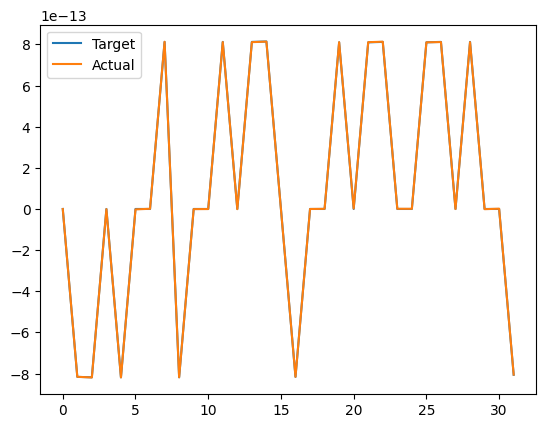

In [10]:
i = 0
psi_ = H0.psi(i, dagger=True) @ H0.vac
H0_psi_ = (H_tfim) @ psi_
plt.plot(H0.bdg_evals_sorted[i] * psi_, label="Target")
plt.plot(H0_psi_, label="Actual")
plt.legend()

# Loschmidt amplitude

$H = \sum_{j}{X_{i}X_{i+1}}$

Eigenvectors numerical incompabillity
U, V numerical incompabillity
True


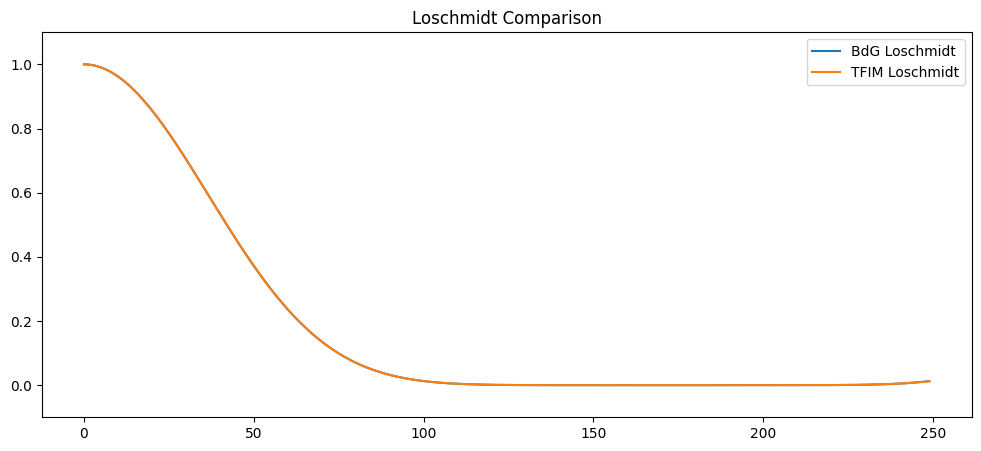

In [23]:
n = 7
eigenvalue_index = range(n)
k = 1e-1

mu = np.zeros(n) + k
mu[0] = mu[-1] = 1e1
H = kitaev_chain_model(n, mu, 1 - k, 1 - k)
H1 = kitaev_chain_model(n, k, 1 - k, 1 - k)

H.bdg_eigen()
H.tfim_vac_from_intersections()
U_bdg = U(H1.bdg_hamiltonian())

H_tfim = H1.tfim_hamiltonian_JW()
tfim_energies, _ = np.linalg.eigh(H_tfim)
U_tfim = U(0.5 * H_tfim)#(H_tfim - tfim_energies[0] * np.eye(H1.N)))

dt = 0.02
duration = 5
t_range = np.arange(0, duration, dt)

L_bdg = np.array([np.linalg.det(H.bdg_evecs_sorted[:, eigenvalue_index].T.conj() @ U_bdg(t) @ H.bdg_evecs_sorted[:, eigenvalue_index]) for t in t_range])

L_initial = np.hstack([H.psi(i, dagger=True) @ H.vac for i in eigenvalue_index])
L_tfim = np.array([np.linalg.det(L_initial.T.conj() @ U_tfim(t) @ L_initial) for t in t_range])

print(np.allclose(np.abs(L_bdg) ** ((n - 2) / 2), np.abs(L_tfim)))

plt.figure(figsize=(12,5))
plt.plot(np.abs(L_bdg ** ((n - 2) / 2)), label="BdG Loschmidt")
plt.plot(np.abs(L_tfim), label="TFIM Loschmidt")
plt.ylim(-.1, 1.1)
plt.title("Loschmidt Comparison")
plt.legend()
plt.show()

